# Analyzing inconsistencies in the JEFF-4.0T0 plutonium-237 evaluation

In [1]:
import sandy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

The JEFF-4.0T0 evaluation for Pu-237 is taken from the OECD/NEA website.

In [3]:
tape = sandy.get_endf6_file("jeff_33", "xs", 942390)

In [4]:
mf5455 = tape.read_section(tape.mat[0], 5, 455)
len(mf5455["PDISTR"])

8

In [5]:
dfs = []
ein = 30000000.0
for group, v in mf5455["PDISTR"].items():
    x = v["EIN"][ein]
    series = pd.Series(x["EDISTR"], index=x["EOUT"], name=group + 1)
    series.index.name = "EOUT"
    dfs.append(series)
data = pd.DataFrame(dfs).T
data.columns.name = "GROUP"
data = data.stack().rename("VAL").reset_index()
data["GROUP"] = data["GROUP"].astype("category")

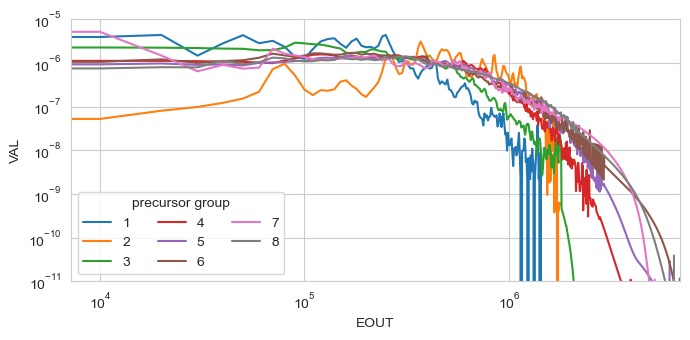

In [6]:
fig, ax = plt.subplots(figsize=(7, 3.5), dpi=100)

sns.lineplot(data=data, x="EOUT", y="VAL", hue="GROUP", ax=ax)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([None, data.EOUT.max()])
ax.set_ylim([1e-11, 1e-5])

ax.legend(loc=3, title="precursor group", ncol=3)

fig.tight_layout();

In [7]:
mf518 = tape.read_section(tape.mat[0], 5, 18)

In [8]:
dfs = []
for ein, x in mf518["PDISTR"][0]["EIN"].items():
    series = pd.Series(x["EDISTR"], index=x["EOUT"], name=ein)
    series.index.name = "EOUT"
    dfs.append(series)
data = pd.DataFrame(dfs).T
data.columns.name = "EIN"
data = data.stack().rename("VAL").reset_index()
e = [1e3, 1e4, 1e5, 1e6, 2e6, 3e6, 8e6, 1e7]  # select only few energies
data = data[data.EIN.isin(e)].reset_index(drop=True)
data["EIN"] = data["EIN"].astype('category')

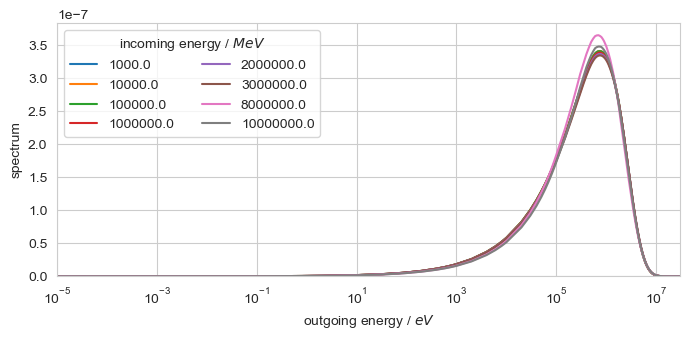

In [9]:
fig, ax = plt.subplots(figsize=(7, 3.5), dpi=100)

sns.lineplot(data=data, x="EOUT", y="VAL", hue="EIN", ax=ax)

ax.set_xscale("log")
ax.set_xlim([data.EOUT.min(), data.EOUT.max()])
ax.set_ylim([0, None])
ax.set_xlabel("outgoing energy / $eV$")
ax.set_ylabel("spectrum")
ax.legend(title="incoming energy / $MeV$", ncol=2)

fig.tight_layout();

In [10]:
nuprompt = tape.read_section(tape.mat[0], 1, 456)
nuprompt

{'MAT': 9437,
 'MF': 1,
 'MT': 456,
 'ZA': 94239.0,
 'AWR': 236.9984,
 'LNU': 2,
 'NBT': [3201],
 'INT': [2],
 'E': array([1.00e-05, 3.00e-05, 1.00e-03, ..., 2.90e+07, 2.95e+07, 3.00e+07]),
 'NU': array([2.861848, 2.861848, 2.861848, ..., 6.48843 , 6.53631 , 6.61775 ])}

In [11]:
nutot = tape.read_section(tape.mat[0], 1, 452)
nuprompt = tape.read_section(tape.mat[0], 1, 456)
nudel = tape.read_section(tape.mat[0], 1, 455)

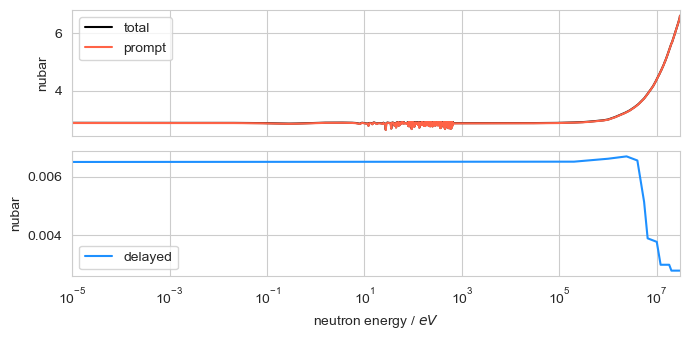

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(7, 3.5), dpi=100, sharex=True)

ax = axs[0]
pd.Series(nutot["NU"], index=nutot["E"]).plot(ax=ax, label="total", color="black")
pd.Series(nuprompt["NU"], index=nuprompt["E"]).plot(ax=ax, label="prompt", color="tomato")
ax.set_ylabel("nubar")
ax.legend()

ax = axs[1]
pd.Series(nudel["NU"], index=nudel["E"]).plot(ax=ax, label="delayed", color="dodgerblue")

ax.set_xscale("log")
ax.set_xlim([1e-5, 3e7])
ax.set_xlabel("neutron energy / $eV$")
ax.set_ylabel("nubar")
ax.legend()

fig.tight_layout();

In [13]:
pendf = tape.get_pendf(err=0.1)
xs = sandy.Xs.from_endf6(pendf)

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


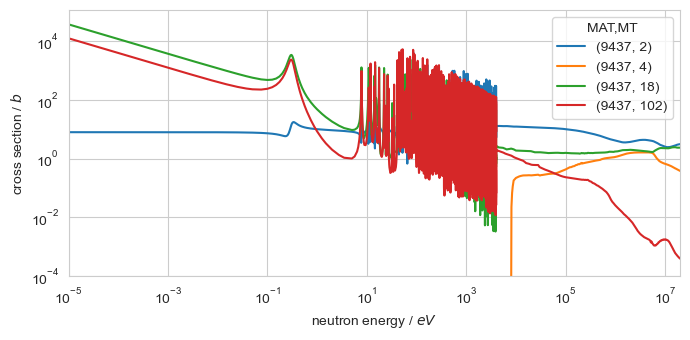

In [14]:
fig, ax = plt.subplots(figsize=(7, 3.5), dpi=100)

mat = pendf.mat[0]
xs.data[[(mat, 2), (mat, 4), (mat, 18), (mat, 102)]].plot(ax=ax)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e-5, 2e7])
ax.set_ylim([1e-4, None])
ax.set_xlabel("neutron energy / $eV$")
ax.set_ylabel("cross section / $b$")

fig.tight_layout();